# Graph Neural Network

Author: Adam 

## Tensorflow GNN
```latex
@article{tfgnn,
  author  = {Oleksandr Ferludin and Arno Eigenwillig and Martin Blais and
             Dustin Zelle and Jan Pfeifer and Alvaro Sanchez{-}Gonzalez and
             Wai Lok Sibon Li and Sami Abu{-}El{-}Haija and Peter Battaglia and
             Neslihan Bulut and Jonathan Halcrow and
             Filipe Miguel Gon{\c{c}}alves de Almeida and Pedro Gonnet and
             Liangze Jiang and Parth Kothari and Silvio Lattanzi and 
             Andr{\'{e}} Linhares and Brandon Mayer and Vahab Mirrokni and
             John Palowitch and Mihir Paradkar and Jennifer She and
             Anton Tsitsulin and Kevin Villela and Lisa Wang and David Wong and
             Bryan Perozzi},
  title   = {{TF-GNN:} Graph Neural Networks in TensorFlow},
  journal = {CoRR},
  volume  = {abs/2207.03522},
  year    = {2023},
  url     = {http://arxiv.org/abs/2207.03522},
}

@misc{StellarGraph,
  author = {CSIRO's Data61},
  title = {StellarGraph Machine Learning Library},
  year = {2018},
  publisher = {GitHub},
  journal = {GitHub Repository},
  howpublished = {\url{https://github.com/stellargraph/stellargraph}},
}
```

## Paper

Simplifying Graph Convolutional Networks (https://arxiv.org/abs/1902.07153)
Felix Wu, Tianyi Zhang, Amauri Holanda de Souza Jr., Christopher Fifty, Tao Yu, Kilian Q. Weinberger

In [4]:
import os
from neo4j import GraphDatabase
import numpy as np
from dotenv import load_dotenv

load_dotenv()
client_id = os.getenv("N4J_USER")
client_secret = os.getenv("N4J_PW")


class RedditDataset():
    def read(self):
        driver = GraphDatabase.driver(
            "bolt://localhost:7687", auth=(client_id, client_secret)
        )

        with driver.session() as session:
            mhlabel_nodes = session.run("MATCH (n:Subreddit) RETURN n.name as name")
            mhlabels = {record["name"]: idx for idx, record in enumerate(mhlabel_nodes)}

            word_nodes = session.run("MATCH (n:Word) RETURN n.name as name")
            words = {
                record["name"]: idx + len(mhlabel_nodes)
                for idx, record in enumerate(word_nodes)
            }

            edge_results = session.run(
                "MATCH (n:Word)-[r]->(m:Subreddit) RETURN n.name as source, m.name as target"
            )
            edges = [
                (words[record["source"]], mhlabels[record["target"]])
                for record in edge_results
            ]

        num_nodes = len(mhlabels)
        adj_matrix = np.zeros((num_nodes, num_nodes))
        for src, dst in edges:
            adj_matrix[src][dst] = 1

        node_features = np.eye(num_nodes)
        labels = np.zeros((num_nodes, 1))

        return node_features, adj_matrix, labels


dataset = RedditDataset()

## Supervised graph classification Problem

Posts are graphs, and graphs are within a mental health category.
We need to classify the graph.

- paper: https://arxiv.org/abs/1902.06673
- see: https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html#Edge-features
- see: https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/
# GNNs

GNNS take graphs as inputs, and perform trained transformations and aggregations of features across the nodes and edges.
GNNs maintain vectors for each node - the node state, similar to a neuron.

The GNN updates the states with trainable functions: message passing, convolutions or attention. An update is
1. States are broadcas across edges.
2. Message is computed as an aggregate function.
3. Nodes pool messages using a fucntion or attention model.
4. Each node updates the state - using a NN possible.
5. Process is repeated.
6. Hetero graphs get seperate wieghts. Irregular and not possible with a normal tensor (similar to NLP) and needs a graph tensor (ragged tensor), this also store direction.
7. Trained e2e by BP to reduct loss.
8. Reading out the final GNN  state

Arch:
- Encoder for input features
- GNN for state update
- A prediction head
- Node sets - feature containers + size info, -1 being latent and ragged. All nodes in a set (id) have same features.
- lantent nodes - nodes with out features whose embeddings will be calc.
- Edge Sets (source and target), ead set also has adjancy object.
- homo graphs - edge sets on single type of node (both source and target)
- Context or Global features. The ground truth for the whole graph or sub-graph.

In training, a seed node or sub-graph is required. Graph classification, take tensor with hidden states and apply a classifier on top, this is for an inplicit readout for a sinlge node of interest, or direct readout for a feture tensor. Can aklso have a special node for structre readouts.

# Graph Schema

- see: tensorflow_gnn/proto/graph_schema.proto:GraphSchema
- see schema: ./gnn/mh_gnn.pbtxt

- Validate schema: `tfgnn_validate_graph_schema --logtostderr --graph_schema=gnn/mh_graph.pbtxt`
- Generatete mock training data: `tfgnn_generate_training_data --graph_schema=gnn/mh_graph.pbtxt --examples=gnn/mh_graph.tfrecord --file_format=tfrecord --num_examples=100`

In [5]:
import numpy as np
import pandas as pd
from random import random


def generate_graph_data(num_word_nodes, embedding_dim=4):
    word_embeddings = np.random.rand(num_word_nodes, embedding_dim)
    nodes_df = pd.DataFrame(
        {"embedding": [random() for i in range(num_word_nodes)]},
        index=[f"word_{i}" for i in range(num_word_nodes)],
    )
    edges = []
    for i in range(num_word_nodes):
        if i < num_word_nodes - 1:
            edges.append(
                (
                    f"word_{i}",
                    f"word_{i+1}",
                    random(),
                )
            )
        if i > 0 and i % 2:
            edges.append(
                (
                    f"word_{i-1}",
                    f"word_{i}",
                    random(),
                )
            )
    edge_df = pd.DataFrame(edges, columns=["source", "target", "embedding"])

    return nodes_df, edge_df


num_word_nodes_per_graph = 15
nodes_df, edge_df = generate_graph_data(num_word_nodes_per_graph)
nodes_df, edge_df

(         embedding
 word_0    0.698528
 word_1    0.954145
 word_2    0.244901
 word_3    0.479621
 word_4    0.064504
 word_5    0.395752
 word_6    0.231932
 word_7    0.870737
 word_8    0.840162
 word_9    0.260917
 word_10   0.743047
 word_11   0.152208
 word_12   0.804912
 word_13   0.325615
 word_14   0.991867,
      source   target  embedding
 0    word_0   word_1   0.699314
 1    word_1   word_2   0.180028
 2    word_0   word_1   0.750050
 3    word_2   word_3   0.773264
 4    word_3   word_4   0.930959
 5    word_2   word_3   0.400419
 6    word_4   word_5   0.235151
 7    word_5   word_6   0.251123
 8    word_4   word_5   0.393127
 9    word_6   word_7   0.563526
 10   word_7   word_8   0.586991
 11   word_6   word_7   0.684202
 12   word_8   word_9   0.754558
 13   word_9  word_10   0.403002
 14   word_8   word_9   0.223353
 15  word_10  word_11   0.496499
 16  word_11  word_12   0.754989
 17  word_10  word_11   0.390266
 18  word_12  word_13   0.464827
 19  word_13  word_

In [6]:
from stellargraph import StellarGraph
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

num_graphs = 50
graphs = []
labels = []

for _ in range(num_graphs):
    nodes_df, edge_df = generate_graph_data(num_word_nodes_per_graph)
    g = StellarGraph(nodes_df, edge_df)
    graphs.append(g)
    label = np.random.randint(0, 5)
    labels.append(label)

# labels = to_categorical(labels, num_classes=5)
graph_df = pd.DataFrame({"Graph": graphs, "Label": list(labels)})
graph_df.head(3)

,Graph,Label
0,<stellargraph.core.graph.StellarGraph object a...,4
1,<stellargraph.core.graph.StellarGraph object a...,1
2,<stellargraph.core.graph.StellarGraph object a...,0


In [7]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 15, Edges: 21

 Node types:
  default: [15]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [21]
        Weights: all 1 (default)
        Features: float32 vector, length 1


# GCN Architecture

![alt](./misc/gcn_arch.PNG)

Generator feeds data to the NN.

- 2 convolutional layers (64-dimensional output features map in each) 
- 2 fully connected layers (producing 32-and 2-dimensional output features, respectively) to predict the mental health or lack off class probabilities. 
- 1 head of graph attention was used in every convolutional layer to implement the filters together with mean-pooling for dimensionality reduction.
- We used Scaled Exponential Linear Unit (SELU) as non-linearity throughout the entire network.
- Hinge loss was employed to train the neural network (we preferred hinge loss to the more commonly
- used mean cross entropy as it outperformed the latter in early experiments). No regularization was
used with our model

In [8]:
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph.layer import GraphAttention, MeanPoolingAggregator
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

generator = PaddedGraphGenerator(graphs=graphs)

from tensorflow.keras.losses import categorical_hinge


def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["selu", "selu"],
        generator=generator,
        dropout=0.5,
        pooling=None,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="selu")(x_out)
    predictions = Dense(units=6, activation="softmax")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=Adam(0.005),
        loss=categorical_hinge,  # Use categorical hinge loss
        metrics=[categorical_accuracy],
    )

    return model


epochs = 25  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 2  # the number of repeats for repeated k-fold cross validation
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)


def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=0,
        callbacks=[es],
    )
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("categorical_accuracy")]

    return history, test_acc


def get_generators(train_index, test_index, graph_labels, batch_size):
    train_targets = graph_labels.iloc[train_index].values
    test_targets = graph_labels.iloc[test_index].values
    train_targets = to_categorical(train_targets, num_classes=6)
    test_targets = to_categorical(test_targets, num_classes=6)
    train_gen = generator.flow(
        train_index,
        targets=train_targets,
        batch_size=batch_size,
    )
    test_gen = generator.flow(test_index, targets=test_targets, batch_size=batch_size)

    return train_gen, test_gen


test_accs = []

from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=folds, shuffle=True)

for i, (train_index, test_index) in enumerate(
    stratified_kfold.split(
        graph_df,
        graph_df["Label"],
    )
):
    print(f"Training and evaluating on fold {i+1} out of {folds}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_df["Label"], batch_size=30
    )

    model = create_graph_classification_model(generator)
    assert model is not None

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3f}% and std: {np.std(test_accs)*100:.2f}%"
)

Training and evaluating on fold 1 out of 10...


c:\Users\adamd\.conda\envs\gnn\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Training and evaluating on fold 2 out of 10...
Training and evaluating on fold 3 out of 10...
Training and evaluating on fold 4 out of 10...
Training and evaluating on fold 5 out of 10...
Training and evaluating on fold 6 out of 10...
Training and evaluating on fold 7 out of 10...
Training and evaluating on fold 8 out of 10...
Training and evaluating on fold 9 out of 10...
Training and evaluating on fold 10 out of 10...
Accuracy over all folds mean: 22.000% and std: 14.00%


Text(0, 0.5, 'Count')

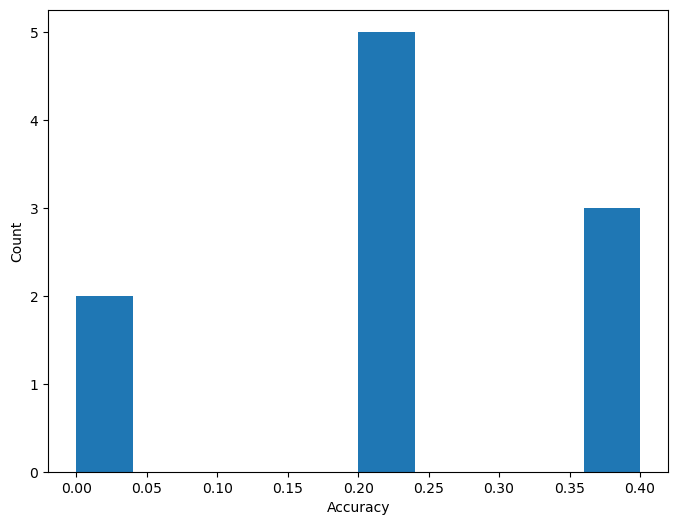

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")